In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn import preprocessing
from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 7 Ulysses’ Compass

## 7.1. The problem with parameter

In the context of linear Gaussian models, $R^2$ is the most common measure of this kind. Often described as "variance" explained.

### 7.1.1. More parameters (almost) always improve fit

### Code 7.1

In [4]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
        'brain' : [438, 452, 612, 521, 752, 871, 1350],
        'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
df = pd.DataFrame(data=data)
df.head()

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5


### Code 7.2

In [5]:
df['mass_std'] = preprocessing.scale(df['mass'])
df['brain_std'] = preprocessing.scale(df['brain'])
df.head()

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,-0.924151
1,africanus,452,35.5,-0.990494,-0.877225
2,habilis,612,34.5,-1.089544,-0.340930
3,boisei,521,41.5,-0.396198,-0.645948
4,rudolfensis,752,55.5,0.990494,0.128328


### Code 7.3

In [6]:
# define model: brain ~ mass
with pm.Model() as m7_1:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + b*df['mass_std'])
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4861.89draws/s]


In [7]:
# show model summary
varnames = ['~mu']
az.summary(m7_1_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.12,0.49,-0.64,0.90
b,0.70,0.57,-0.17,1.59
log_sigma,0.34,0.21,0.05,0.63


### Code 7.4

In [8]:
# using OLS (ordinary least squares) for regression
X = df['mass_std']
Y = df['brain_std']
model = sm.OLS(Y, X).fit()

# print out the statistics
model.summary()

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              brain_std   R-squared (uncentered):                   0.490
Model:                            OLS   Adj. R-squared (uncentered):              0.405
Method:                 Least Squares   F-statistic:                              5.768
Date:                Fri, 08 May 2020   Prob (F-statistic):                      0.0532
Time:                        22:46:25   Log-Likelihood:                         -7.5748
No. Observations:                   7   AIC:                                      17.15
Df Residuals:                       6   BIC:                                      17.10
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mass_std       0.7001      0.292      2.402      0.053      -0.013       1.413
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# OLS regression using formulas
model = smf.ols('brain_std ~ mass_std', data=df).fit()

# print out the statistics
model.summary()

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Fri, 08 May 2020   Prob (F-statistic):             0.0798
Time:                        22:46:25   Log-Likelihood:                -7.5748
No. Observations:                   7   AIC:                             19.15
Df Residuals:                       5   BIC:                             19.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.22e-16      0.319   6.95e-16      1.000      -0.821       0.821
mass_std       0.7001      0.319      2.192      0.080      -0.121       1.521
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Code 7.5 and Code 7.6

In [10]:
# calculate R^2 manually
def cal_R2(ypred, y):
    resid_var = (ypred-y).var()
    outcome_var = y.var()
    return 1 - resid_var/outcome_var

In [11]:
ypred = model.predict()
cal_R2(ypred, df['brain_std'])

0.4901580479490839

### Code 7.7 - Code 7.10

In [12]:
shared_mass_D1 = shared(df['mass_std'].values)
# define model: brain ~ mass with 1 degree of polynomial
with pm.Model() as m7_1:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + b*shared_mass_D1)
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_1_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_1_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 1 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4410.02draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.14,0.50,-0.64,0.91
b,0.68,0.60,-0.24,1.59
log_sigma,0.35,0.22,0.04,0.61


In [13]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_1_trace, 
                                      samples=1000, 
                                      model=m7_1)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)
shared_mass_D1.set_value(mass_seq)
with m7_1:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_1_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 972.46it/s]
/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 3942.78it/s]


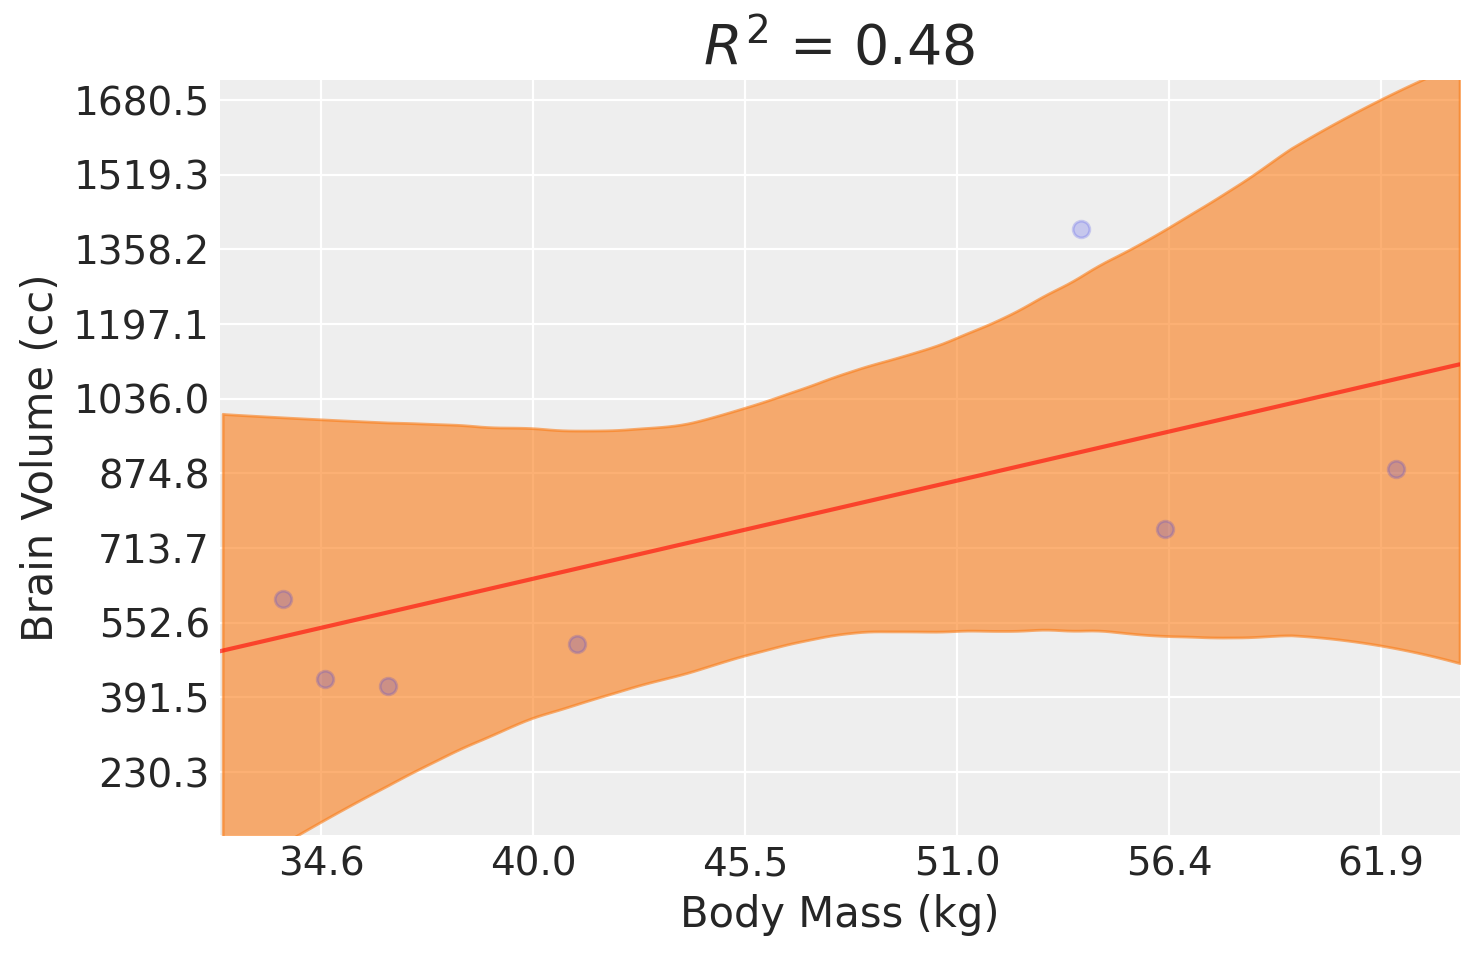

In [14]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

In [15]:
shared_mass_D2 = shared(np.vstack((df['mass_std'], df['mass_std']**2)))
# define model: brain ~ mass with 2 degrees of polynomial
with pm.Model() as m7_2:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=2)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D2))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_2_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_2_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3291.24draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.45,0.75,-0.77,1.60
b[0],0.82,0.61,-0.17,1.75
b[1],-0.45,0.77,-1.67,0.79
log_sigma,0.37,0.22,0.06,0.66


In [16]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_2_trace, 
                                      samples=1000, 
                                      model=m7_2)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)


shared_mass_D2.set_value(np.vstack((mass_seq, mass_seq**2)))
with m7_2:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_2_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 3093.42it/s]


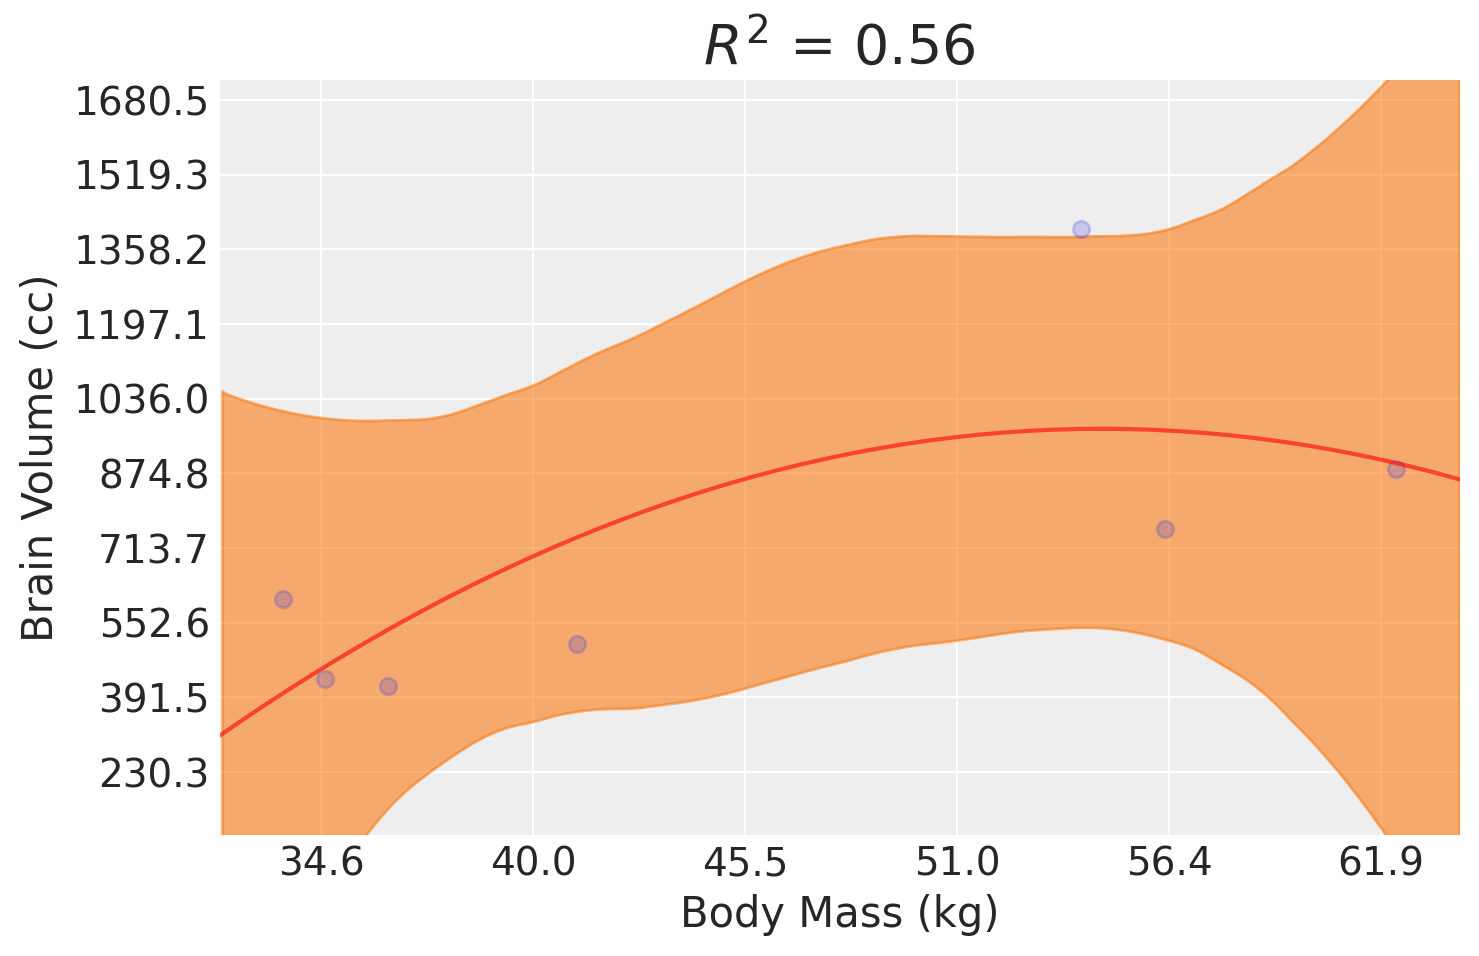

In [17]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

In [18]:
shared_mass_D3 = shared(np.vstack((df['mass_std'], df['mass_std']**2, df['mass_std']**3)))
# define model: brain ~ mass with 3 degrees of polynomial
with pm.Model() as m7_3:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=3)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D3))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_3_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_3_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1930.28draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.29,0.78,-0.90,1.63
b[0],1.64,1.61,-0.94,4.03
b[1],-0.03,1.04,-1.60,1.63
b[2],-0.67,1.20,-2.60,1.15
log_sigma,0.39,0.25,0.05,0.70


In [19]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_3_trace, 
                                      samples=1000, 
                                      model=m7_3)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)


shared_mass_D3.set_value(np.vstack((mass_seq, mass_seq**2, mass_seq**3)))
with m7_3:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_3_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 3755.34it/s]


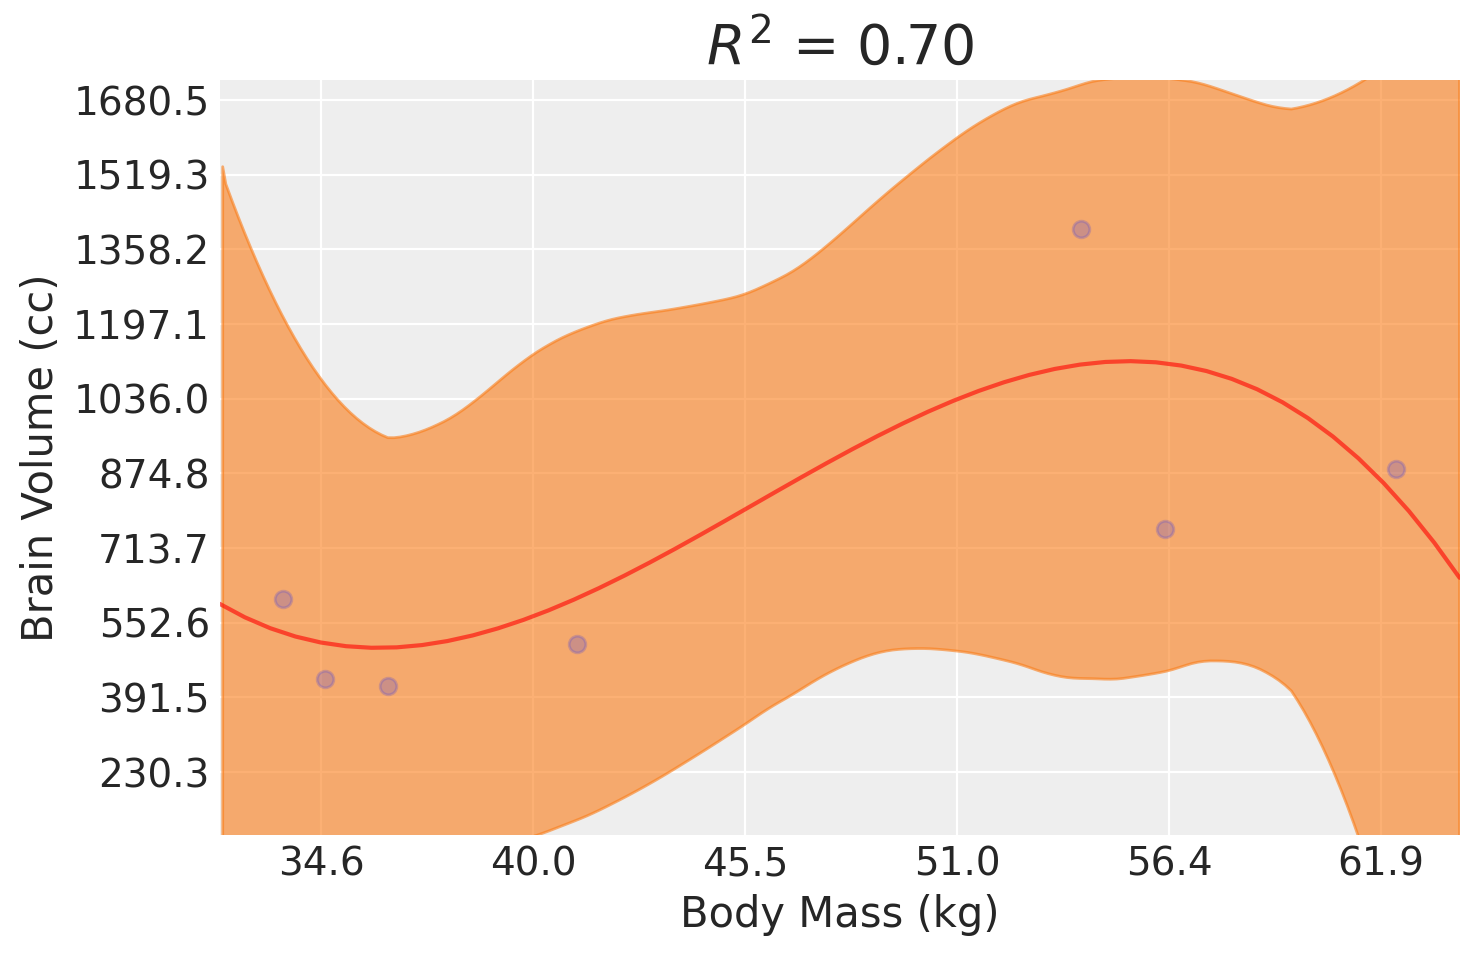

In [20]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

In [21]:
shared_mass_D4 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4)))
# define model: brain ~ mass with 4 degrees of polynomial
with pm.Model() as m7_4:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=4)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D4))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_4_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_4_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 6 divergences: 100%|██████████| 8000/8000 [00:10<00:00, 780.05draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7063146426042165, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.56,0.90,-0.95,1.94
b[0],2.45,2.36,-1.20,6.11
b[1],-1.37,2.82,-5.97,2.94
b[2],-1.60,2.29,-5.19,1.96
b[3],0.93,1.88,-1.89,4.02
log_sigma,0.42,0.27,0.07,0.78


In [22]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_4_trace, 
                                      samples=1000, 
                                      model=m7_4)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)


shared_mass_D4.set_value(np.vstack((mass_seq, 
                                    mass_seq**2, 
                                    mass_seq**3,
                                    mass_seq**4)))
with m7_4:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_4_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 3485.60it/s]


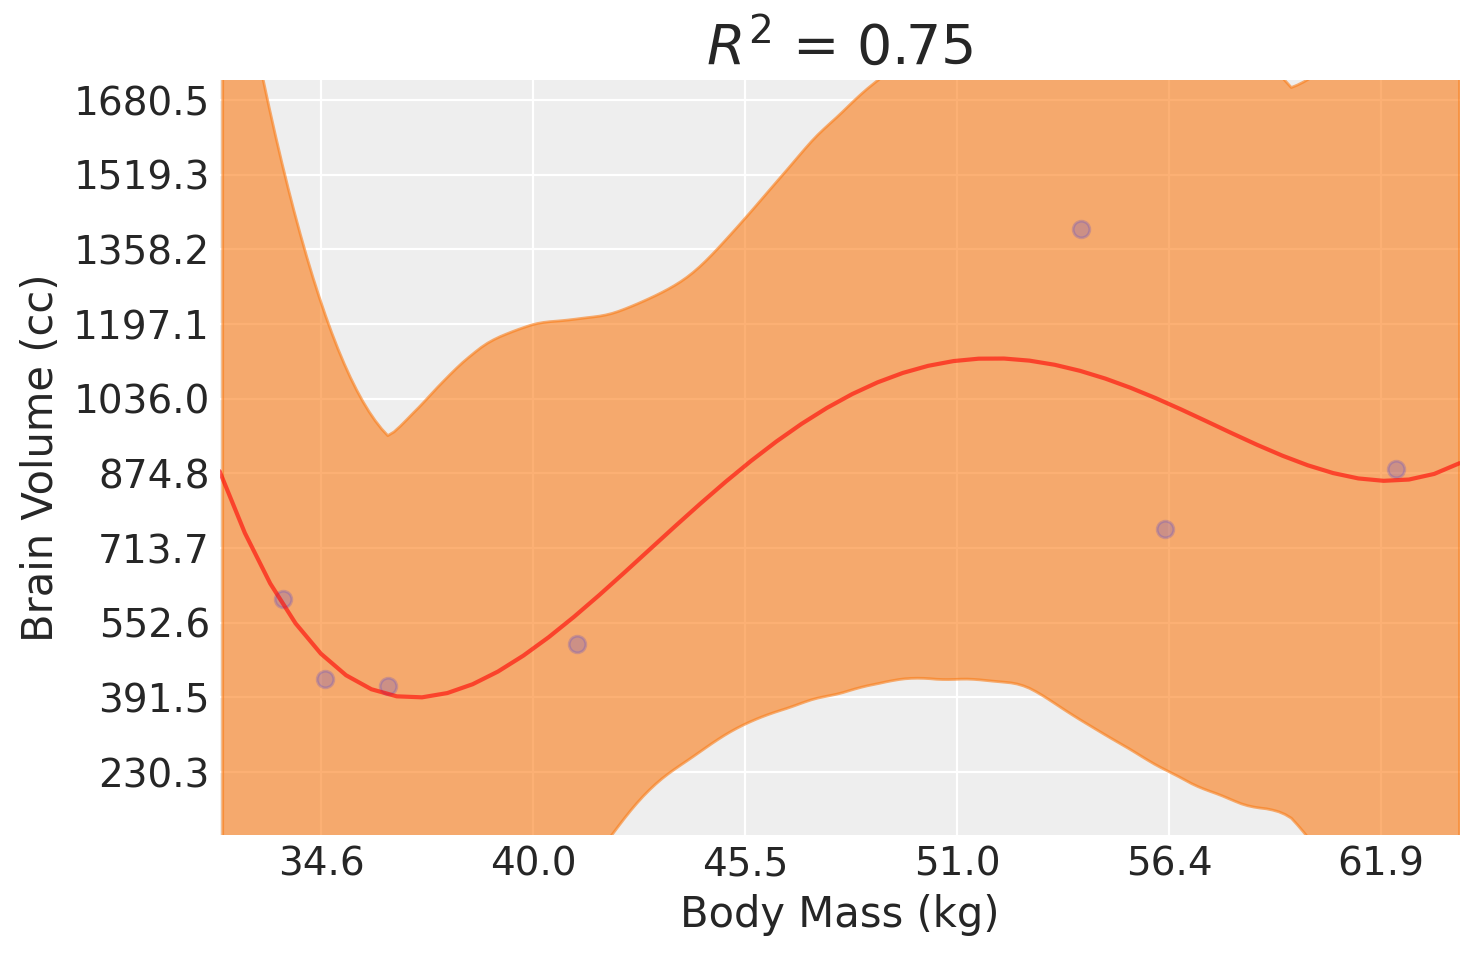

In [23]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

In [24]:
shared_mass_D5 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4,
                                   df['mass_std']**5)))
# define model: brain ~ mass with 5 degrees of polynomial
with pm.Model() as m7_5:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=5)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D5))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_5_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_5_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 35 divergences: 100%|██████████| 8000/8000 [00:23<00:00, 335.43draws/s]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.58,0.87,-0.83,1.97
b[0],3.38,3.34,-1.94,8.59
b[1],-0.76,3.42,-6.39,4.54
b[2],-3.71,6.00,-13.12,5.56
b[3],0.22,2.91,-4.32,4.91
b[4],1.02,2.83,-3.22,5.52
log_sigma,0.43,0.28,0.03,0.78


In [25]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_5_trace, 
                                      samples=1000, 
                                      model=m7_5)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)


shared_mass_D5.set_value(np.vstack((mass_seq, 
                                    mass_seq**2, 
                                    mass_seq**3,
                                    mass_seq**4,
                                    mass_seq**5)))
with m7_5:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_5_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1411.16it/s]


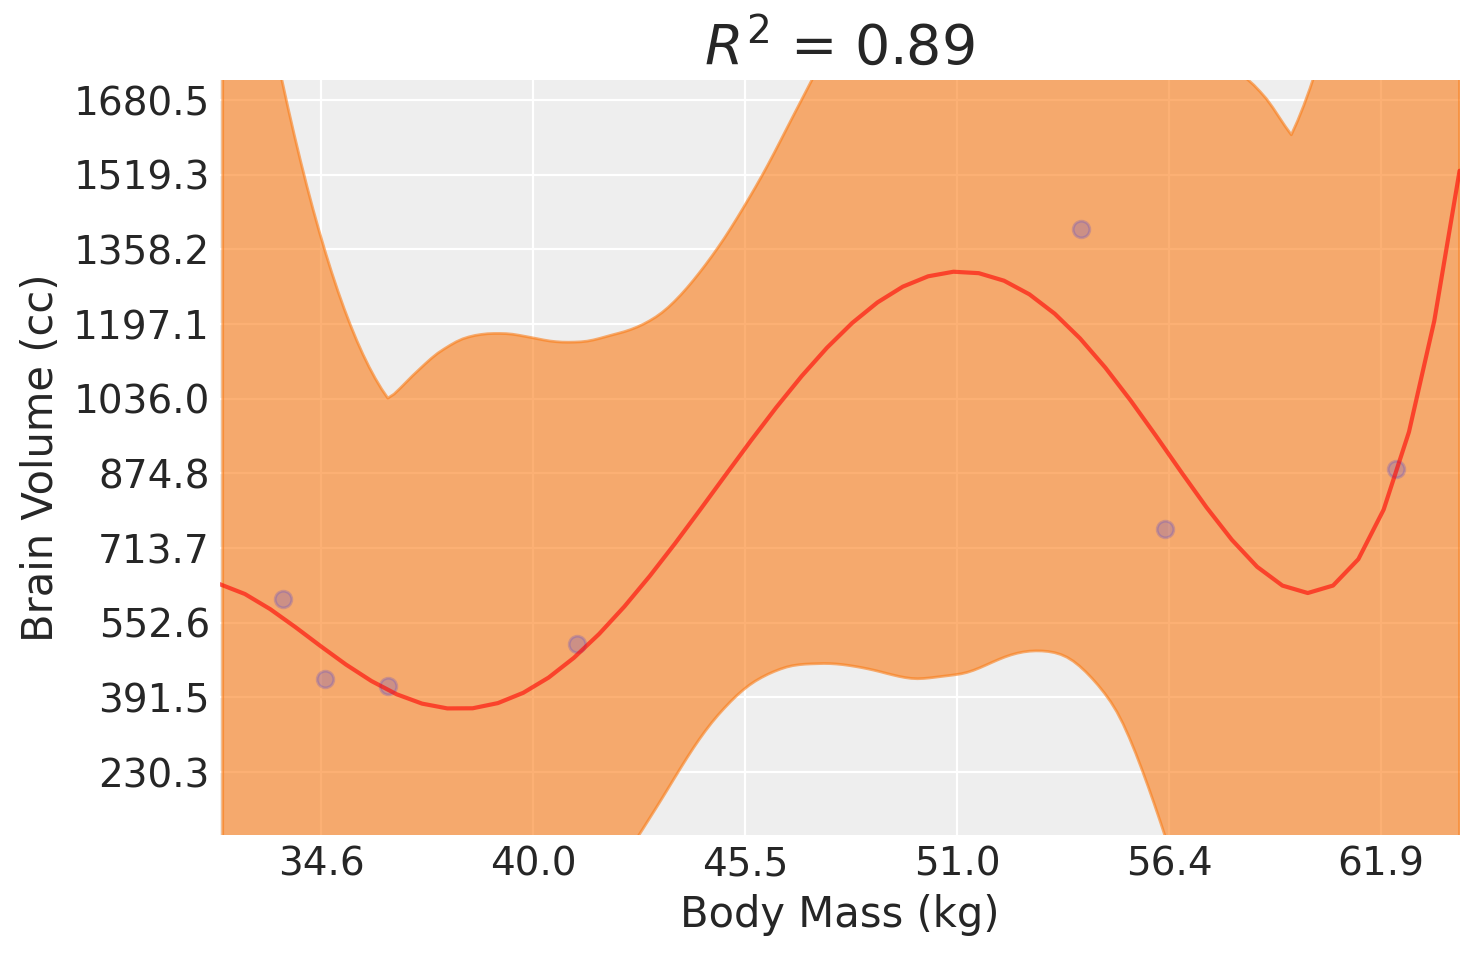

In [26]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

In [27]:
shared_mass_D6 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4,
                                   df['mass_std']**5,
                                   df['mass_std']**6)))
# define model: brain ~ mass with 6 degrees of polynomial
with pm.Model() as m7_6:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=6)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D6))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_6_trace = pm.sample(1000, tune=1000)
    
# show model summary
varnames = ['~mu']
az.summary(m7_6_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 16 divergences: 100%|██████████| 8000/8000 [00:36<00:00, 218.46draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.53,0.90,-0.91,1.96
b[0],3.21,3.59,-2.10,9.24
b[1],0.52,4.58,-6.73,7.80
b[2],-2.63,6.82,-13.68,7.66
b[3],-2.40,7.10,-13.30,9.18
b[4],0.07,3.78,-5.97,6.06
b[5],1.23,3.08,-3.95,5.88
log_sigma,0.46,0.30,0.05,0.85


In [28]:
# sampling from posterior
pred = pm.sample_posterior_predictive(trace=m7_6_trace, 
                                      samples=1000, 
                                      model=m7_6)
# re-sampling for mu
mass_seq = np.linspace(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15, 50)


shared_mass_D6.set_value(np.vstack((mass_seq, 
                                    mass_seq**2, 
                                    mass_seq**3,
                                    mass_seq**4,
                                    mass_seq**5,
                                    mass_seq**6)))
with m7_6:
    brain_post = pm.sample_posterior_predictive(
        trace = m7_6_trace, 
        var_names=['mu'], 
        samples=1000
    )

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 3932.16it/s]


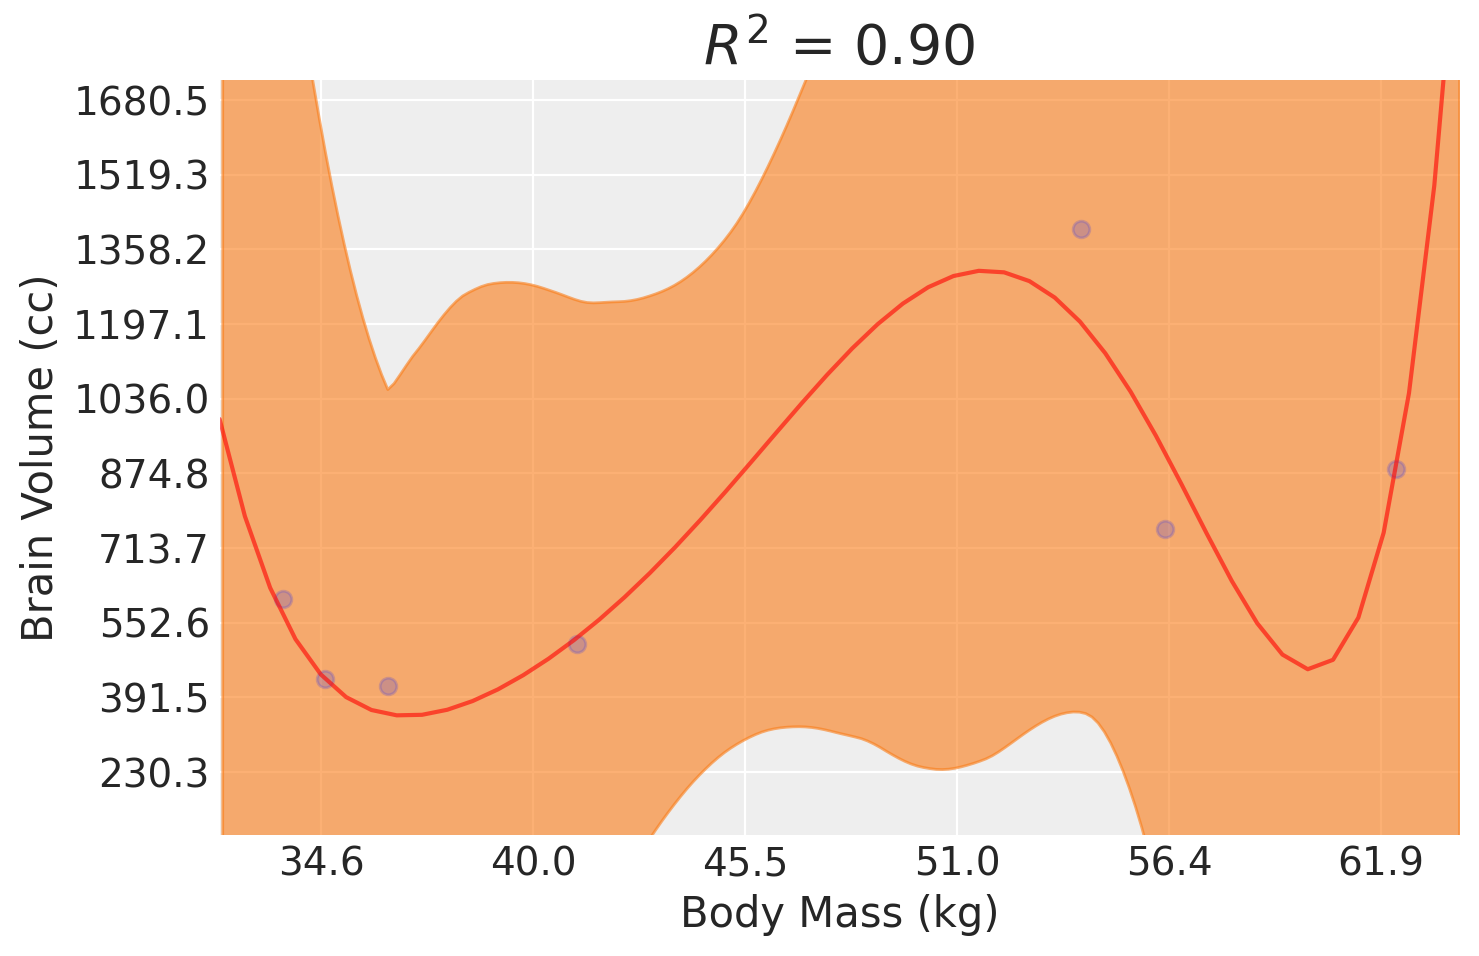

In [29]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass_std'], df['brain_std'], 'o', alpha=0.2)
# mean
plt.plot(mass_seq, brain_post['mu'].mean(0), "r", alpha=0.6)
# CI for mean
az.plot_hpd(mass_seq, brain_post['mu'], color='C1', fill_kwargs={'alpha': 0.6})
plt.xlabel('Body Mass (kg)', fontsize=15)
plt.ylabel('Brain Volume (cc)', fontsize=15)
at = np.arange(-5, 5, 0.5)
plt.xticks(at, np.round(at * df['mass'].std() + df['mass'].mean(), 1));
plt.yticks(at, np.round(at * df['brain'].std() + df['brain'].mean(), 1));
plt.xlim(df['mass_std'].min()-0.15, df['mass_std'].max()+0.15)
plt.ylim(df['brain_std'].min()-1, df['brain_std'].max()+1)
plt.title('$R^2$ = {0:.2f}'.format(cal_R2(pred['brain_std'].mean(0), df['brain_std'])), fontsize=20)
plt.show()

### 7.1.2. Too few parameters hurts, too

### Code 7.11


In [30]:
df_new = df.drop(df.index[-1])
df_new

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,-0.924151
1,africanus,452,35.5,-0.990494,-0.877225
2,habilis,612,34.5,-1.089544,-0.340930
3,boisei,521,41.5,-0.396198,-0.645948
4,rudolfensis,752,55.5,0.990494,0.128328
5,ergaster,871,61.0,1.535266,0.527197


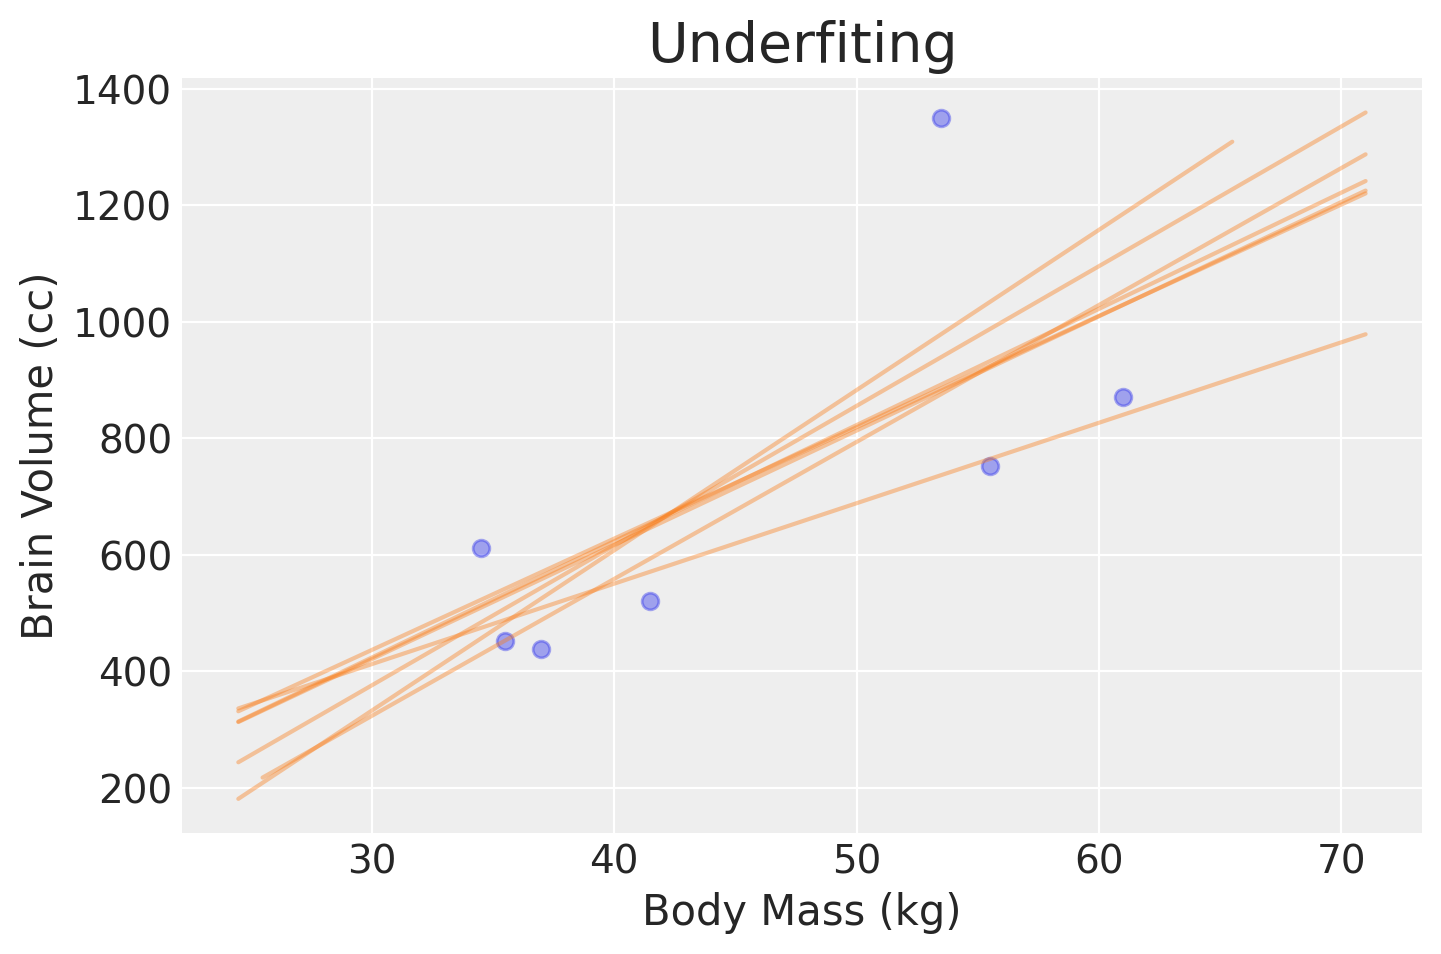

In [31]:
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass'], df['brain'], 'o', alpha=0.4)
plt.xlabel('Body Mass (kg)', fontsize=15);
plt.ylabel('Brain Volume (cc)', fontsize=15)
plt.title('Underfiting', fontsize=20)
for i in range(len(df)):
    # drop one data at a time
    df_new = df.drop(df.index[-i])
    # OLS model
    model = smf.ols('brain ~ mass', data=df_new).fit()
    # add constant to new data frame with mass
    x = sm.add_constant(df_new['mass']) 
    # create linspace dataframe
    x_seq = pd.DataFrame({'mass': np.linspace(x['mass'].min()-10, x['mass'].max()+10, 50)})
    # add constant to newly created linspace dataframe
    x_pred = sm.add_constant(x_seq)  
    # calculate predicted values
    y_pred = model.predict(x_pred)
    # plot lines
    plt.plot(x_seq, y_pred, '-C1', alpha=0.4)

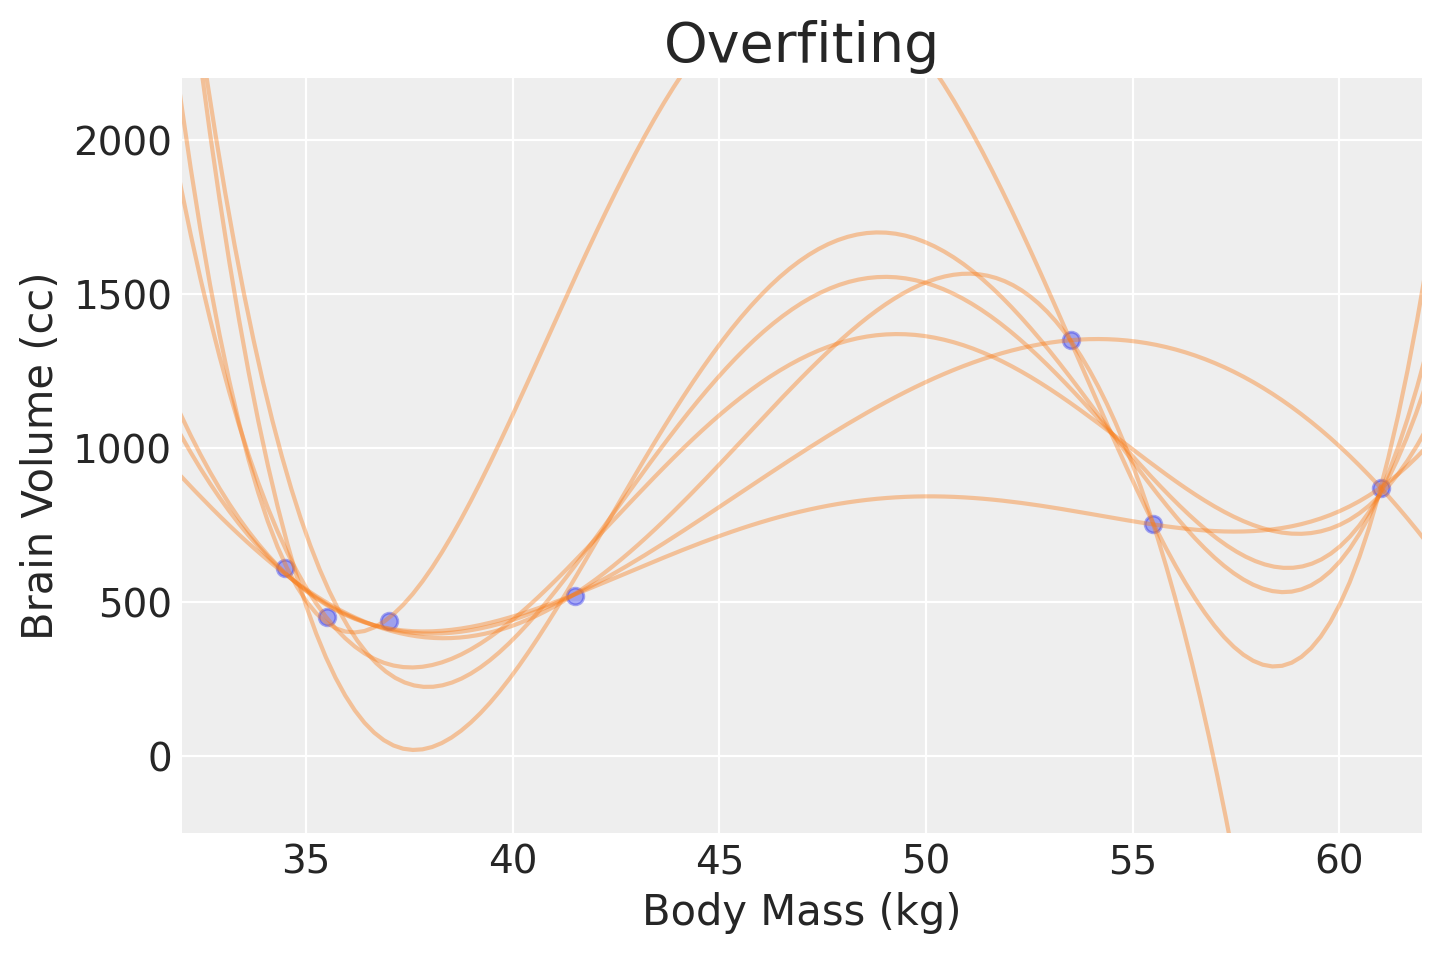

In [32]:
fig = plt.figure(figsize=(8, 5))
plt.plot(df['mass'], df['brain'], 'o', alpha=0.4)
plt.xlabel('Body Mass (kg)', fontsize=15);
plt.ylabel('Brain Volume (cc)', fontsize=15)
plt.title('Overfiting', fontsize=20)
for i in range(len(df)):
    # drop one data at a time
    df_new = df.drop(df.index[-i])
    # OLS model
    model = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=df_new).fit()
    # add constant to new data frame with mass
    x = sm.add_constant(df_new['mass']) 
    # create linspace dataframe
    x_seq = pd.DataFrame({'mass': np.linspace(x['mass'].min()-10, x['mass'].max()+10, 200)})  
    # add constant to newly created linspace dataframe
    x_pred = sm.add_constant(x_seq)  
    # calculate predicted values
    y_pred = model.predict(x_pred['mass'])
    # plot lines
    plt.plot(x_seq, y_pred, '-C1', alpha=0.4)
    plt.xlim(32,62)
    plt.ylim(-250, 2200)

**Bias and variance.** The underfitting/overfitting dichotomy is often described as the bias-variance trade-off. While not exactly the same distinction, the bias-variance trade-off addresses the same problem. “Bias” is related to underfitting, while “variance” is related to overfitting. These terms are confusing though, because they are used in many different ways in different contexts, even within statistics. The term “bias” also sounds like a bad thing, even though increasing bias often leads to better predictions. For these reasons, this book prefers underfitting/overfitting, but you should expect to see similar examples discussed as bias/variance.

## 7.2. Entropy and accuracy

### 7.2.1. Firing the weatherperson

In the statistics literature, you will sometimes see this measure of accuracy called the
***log scoring rule***, because typically we compute the logarithm of the joint probability and report that. 

### 7.2.2. Information and uncertainty.

**Information**: The reduction in uncertainty when we learn an outcome.

**Information entropy** If there are $n$ different possible events and each event $i$ has probability $p_i$, and we call the list of probabilities $p$, then the unique measure of uncertainty we seek is:

$H(p) = -Elog(p_i)=-\sum_{i=1}^{n}log(p_i)$

**The uncertainty contained in a probability distribution is the average log-probability of an event.**


### Code 7.12

In [33]:
p = [0.3, 0.7]
-sum(p*np.log(p))

0.6108643020548935

### 7.2.3. From entropy to accuracy

**Divergence**: The additional uncertainty induced by using probabilities from one distribution to describe another distribution.


This is often known as Kullback-Leibler divergence or simply K-L divergence, named after the people who introduced it for this purpose.

In plainer language, the divergence is the average difference in $log$ probability between the target ($p$) and model ($q$). 

$D_{KL}(p,q) = \sum_{i=1}p_i(log(p_i)-log(q_i))$


An important practical consequence of this asymmetry, in a model fitting context, is that if we use a distribution with high entropy to approximate an unknown true distribution of events, we will reduce the distance to the truth and therefore the error. 

### 7.2.4. Estimating divergence

An important practical consequence of this asymmetry, in a model fitting context, is that if we use a distribution with high entropy to approximate an unknown true distribution of events, we will reduce the distance to the truth and therefore the error. 

### Code 7.13 and Code 7.14

In [34]:
shared_mass_D1 = shared(df['mass_std'].values)
# define model: brain ~ mass with 1 degree of polynomial
with pm.Model() as m7_1:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + b*shared_mass_D1)
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_1_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4863.05draws/s]


In [35]:
# calculate waic
pm.waic(m7_1_trace, m7_1).waic
pm.compare({'m7_1': m7_1_trace}, ic='WAIC')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_1,0,-11.3243,0.989679,0,1,0.580996,0,False,log


In [36]:
az.summary(m7_1_trace)['mean'][:3]

a            0.114
b            0.720
log_sigma    0.342
Name: mean, dtype: float64

In [37]:
theta = az.summary(m7_1_trace)['mean'][:3]
deviance = -2*sum(stats.norm.logpdf(df['brain_std'], loc=theta[0]+theta[1]*df['mass_std'], scale=np.exp(theta[2])))
deviance

19.501284774173826

In [38]:
# OLS regression using formulas
model = smf.ols('brain_std ~ mass_std', data=df).fit()

# calculate deviance (smaller values are better)
deviance = -2*model.llf
deviance

15.149557970245372

### 7.2.5. Scoring the right data

### Code 7.15

In [39]:
shared_mass_D2 = shared(np.vstack((df['mass_std'], df['mass_std']**2)))
# define model: brain ~ mass with 2 degrees of polynomial
with pm.Model() as m7_2:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=2)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D2))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_2_trace = pm.sample(1000, tune=1000)

shared_mass_D3 = shared(np.vstack((df['mass_std'], df['mass_std']**2, df['mass_std']**3)))
# define model: brain ~ mass with 3 degrees of polynomial
with pm.Model() as m7_3:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=3)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D3))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_3_trace = pm.sample(1000, tune=1000)

shared_mass_D4 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4)))
# define model: brain ~ mass with 4 degrees of polynomial
with pm.Model() as m7_4:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=4)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D4))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_4_trace = pm.sample(1000, tune=1000)

shared_mass_D5 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4,
                                   df['mass_std']**5)))
# define model: brain ~ mass with 5 degrees of polynomial
with pm.Model() as m7_5:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=5)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D5))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_5_trace = pm.sample(1000, tune=1000)

shared_mass_D6 = shared(np.vstack((df['mass_std'], 
                                   df['mass_std']**2, 
                                   df['mass_std']**3,
                                   df['mass_std']**4,
                                   df['mass_std']**5,
                                   df['mass_std']**6)))
# define model: brain ~ mass with 6 degrees of polynomial
with pm.Model() as m7_6:
    a = pm.Normal('a', mu=0.5, sd=1)
    b = pm.Normal('b', mu=0, sd=10, shape=6)
    log_sigma = pm.Lognormal('log_sigma', mu=0, sigma=1)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, shared_mass_D6))
    brain_std = pm.Normal('brain_std', mu=mu, sd=np.exp(log_sigma), observed=df['brain_std'])
    m7_6_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2894.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2008.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:08<00:00, 990.53draws/s] 
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains, 46 divergences: 100%|██████████| 8000/8000 [00:20<00:00, 397.09

In [40]:
pm.compare({'m7_1': m7_1_trace,
            'm7_2': m7_2_trace,
            'm7_3': m7_3_trace,
            'm7_4': m7_4_trace,
            'm7_5': m7_5_trace,
            'm7_6': m7_6_trace}, ic='WAIC')

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_1,0,-11.3243,0.989679,0,0.46396,0.58068,0,False,log
m7_2,1,-12.0366,1.41361,0.712297,0.225869,0.522303,0.300538,True,log
m7_3,2,-12.6519,1.82907,1.32758,0.126472,0.610953,0.546555,True,log
m7_4,3,-13.0147,2.07527,1.69041,0.0859928,0.555921,0.48764,True,log
m7_5,4,-13.466,2.30032,2.14166,0.055877,0.515265,0.57825,True,log
m7_6,5,-13.7683,2.48175,2.44401,0.0418297,0.484146,0.61317,True,log


### Code 7.16 - Code 7.18

In [41]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    # generate training samples
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    # generate testing samples
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    # using pymc3
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        trace_m_sim = pm.sample(1000, tune=1000)
    
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    mm_train = np.ones((N,1))
    mm_train = np.concatenate([mm_train, x_train[:, 1:k+1]], axis=1)
    dev_train = -2*sum(stats.norm.logpdf(x_train[:,0], loc=np.matmul(mm_train, vec), scale=1))    
    
    mm_test = np.ones((N,1))
    mm_test = np.concatenate([mm_test, x_test[:, 1:k+1]], axis=1)
    dev_test = - 2*sum(stats.norm.logpdf(x_test[:,0], loc=np.matmul(mm_test, vec), scale=1))    
    
    return np.mean(dev_train), np.mean(dev_test)

In [42]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2093.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1830.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2420.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2147.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 cha

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3019.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2914.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2440.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2512.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 cha

4


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2976.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2411.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2902.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2540.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|████████

5


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2641.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2571.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2695.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2762.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|████████

6


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2901.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3119.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2823.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2977.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
Sa

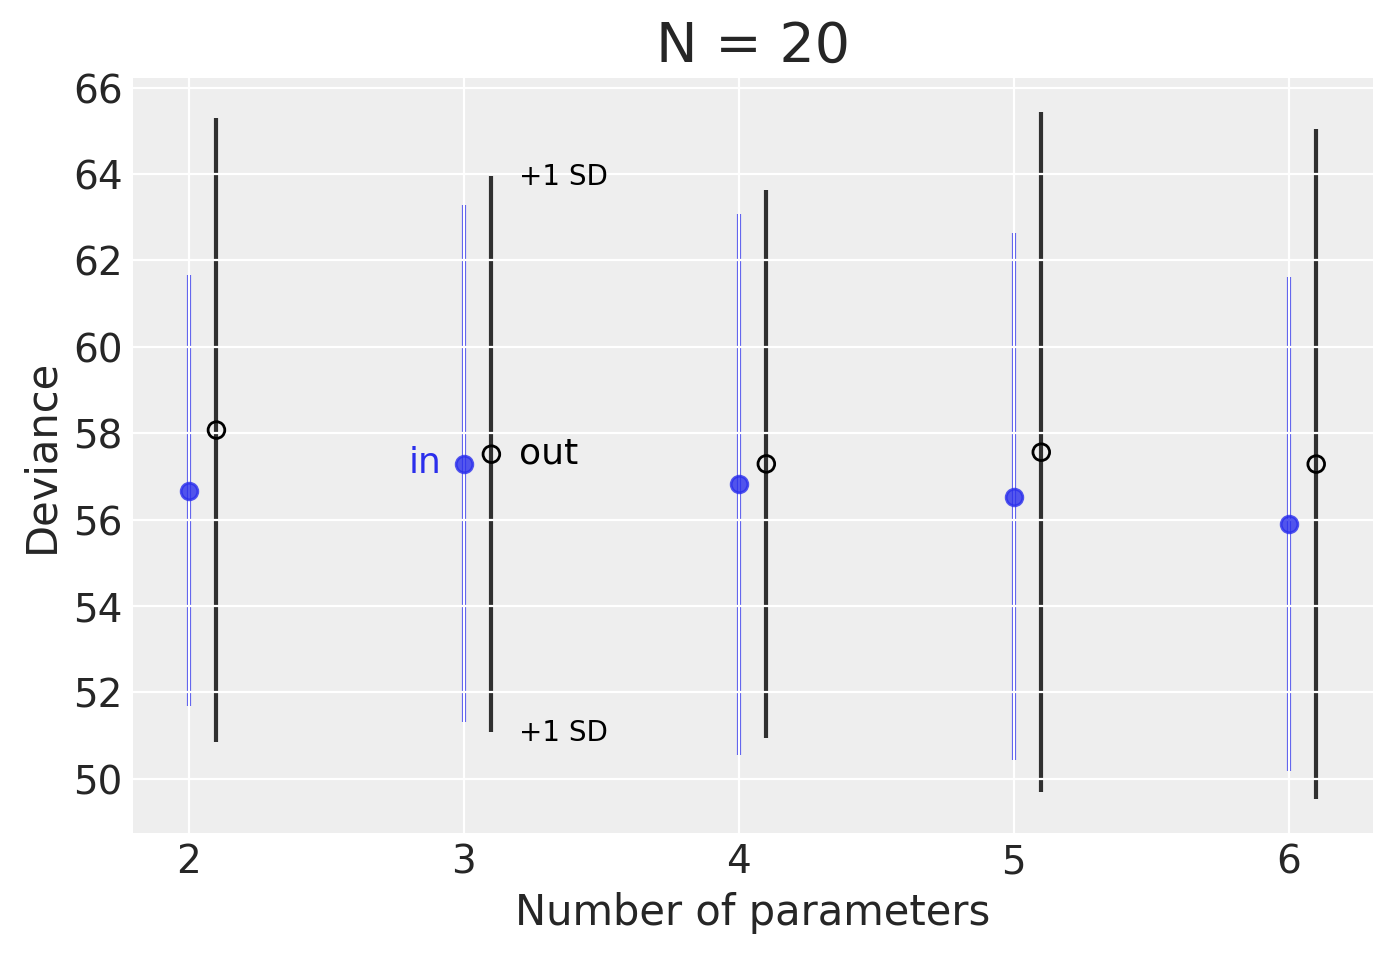

In [43]:
num_param = np.arange(2, param + 1)
# plot results
fig = plt.figure(figsize=(8, 5))
plt.scatter(num_param, r[:, 0], color='C0', alpha=0.8)
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='C0', 
               zorder=-1, alpha=0.8)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.8)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=15)
plt.ylabel('Deviance', fontsize=15)
plt.title('N = {}'.format(n), fontsize=20)
plt.show()

## 7.3. Golem Taming: Regularization

The root of overfitting is a model’s tendency to get overexcited by the training sample. When the priors are flat or nearly flat, the machine interprets this to mean that every parame- ter value is equally plausible. As a result, the model returns a posterior that encodes as much of the training sample—as represented by the likelihood function—as possible.

One way to prevent a model from getting too excited by the training sample is to use a skeptical prior. By “skeptical,” I mean a prior that slows the rate of learning from the sample. The most common skeptical prior is a regularizing prior.

**Ridge regression**. Linear models in which the slope parameters use Gaussian priors, centered at zero, are sometimes known as ridge regression. Ridge regression typically takes as input a precision λ that essentially describes the narrowness of the prior. λ > 0 results in less over- fitting. However, just as with the Bayesian version, if λ is too large, we risk underfitting. 

## 7.4. Predicting predictive accuracy

How can we evaluate our models on it? There are two families of strategies: **cross-validation** and **information criteria**. 

### 7.4.1. Cross-validation

A popular strategy for estimating predictive accuracy is to actually test the model's predictive accuracy on a small part of the sample. This is known as **cross-validation**, leaving out a small chunk of observations from our sample and evaluating the model on the observations that were left out. 

It is extremely common to use the maximum number of folds, resulting in leaving out one unique observation in each fold. This is called **leave-one-out cross-validation** (often abbreviated as LOOCV). 

The approximation goes by the awkward name of **Pareto-smoothed importance sampling cross-validation**. We’ll call it PSIS for short. You’ll also read it as PSIS-LOO, but since the word "loo" means a toilet, let’s try to use a more noble name for this noble estimator. PSIS uses importance sampling, which just means that it uses the importance weights. PSIS uses this distribution to derive more reliable cross-validation score, without actually doing any cross-validation. See more on Page 222.

### 7.4.2. Information criteria

**For ordinary linear regressions with flat priors, the expected overfitting penalty is about twice the number of parameters.**

**Akaike information criterion**, abbreviated AIC. AIC provides a surprisingly simple estimate of the average out-of-sample deviance:

$AIC = D_{train}+2p = -2lppd+2p$ 

where $p$ is the number of free parameters in the posterior distribution.

AIC is an approximation that is reliable only when:
1. The priors are flat or overwhelmed by the likelihood.
2. The posterior distribution is approximately multivariate Gaussian.
3. The sample size $N$ is much greater than the number of parameters $k$.

**Deviance Information Criterion** (DIC). DIC accommodates informative priors, but still assumes that the posterior is multivariate Gaussian and that $N>>k$.

**Widely Applicable Information Criterion** (WAIC) makes no assumption about the shape of the posterior. It provides an approximation of the out-of-sample deviance that converges to the cross-validation approximation in a large sample. But in a finite sample, it can disagree. It can disagree because it has a different target---it isn’t trying to approximate the cross-validation score, but rather guess the out-of-sample K-L Divergence.

WAIC is just the log-posterior-predictive-density (lppd) that we calculated earlier plus a penalty proportional to the variance in the posterior predictions:

$WAIC(y,\Theta) = -2(llpd - \sum_{i}var_{\theta}logp(y_i|\theta))$

where $y$ is the observations and $\Theta$ is the posterior distribution. The penalty term means, "compute the variance in log-probabilities for each observation $i$, and then sum up these variances to get the total penalty." 

Because of the analogy to Akaike’s original criterion, the penalty term in WAIC is sometimes called the **effective number of parameters**, labeled $p_{waic}$. 

**Bayesian information criterion**, abbreviated BIC and also known as the Schwarz criterion, is more commonly juxtaposed with AIC. The choice between BIC or AIC (or neither!) is not about being Bayesian or not. 

### Code 7.19

In [44]:
# load cars data
df = pd.read_csv("Data/cars.csv", sep=",", header=0, index_col=0)
df.head()

,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


In [45]:
# define model: dist ~ speed 
with pm.Model() as m_cars:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b*df['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed=df['dist'])
    m_cars_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2603.68draws/s]


In [46]:
# show model summary
varnames = ['~mu']
az.summary(m_cars_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,-17.56,6.07,-26.24,-7.39
b,3.93,0.38,3.31,4.49
sigma,13.90,1.24,11.82,15.71


### Code 7.20

In [47]:
# calculate log-likelihood of each observation i at each sample s from the posterior
n_samples = 1000
n_cases = df.shape[0]
logprob = np.zeros((n_cases, n_samples))
for s in range(n_samples):
    mu = m_cars_trace['a'][s] + m_cars_trace['b'][s]*df['speed']
    logprob[:,s] = stats.norm.logpdf(df['dist'], loc=mu, scale=m_cars_trace['sigma'][s])
# 50-by-1000 matrix of log-likelihoods
# with observations in rows and samples in columns
np.shape(logprob)

(50, 1000)

### Code 7.21

In [48]:
# compute lppd, the Bayesian deviance
# average the samples in each row, take the log, 
# and add all of the logs together
# (need to do all of the averaging on the log scale)
lppd = np.zeros(n_cases)
for n in range(n_cases):
    lppd[n] = special.logsumexp(logprob[n,:])-np.log(n_samples)

# lppd 
sum(lppd)

-206.5760899637072

### Code 7.22

In [49]:
# compute penalty term, pWAIC:
# compute the variance across samples for
# each observation, then add these together
pWAIC = np.zeros(n_cases)
for n in range(n_cases):
    pWAIC[n] = np.var(logprob[n,:])

# pWAIC
sum(pWAIC)

4.2639697172495055

### Code 7.23

In [50]:
# compute WAIC
-2*(sum(lppd)-sum(pWAIC))

421.6801193619134

In [51]:
-2*pm.waic(m_cars_trace, m_cars).waic

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


421.4452458220819

### Code 7.24

In [52]:
# compute the standard error of WAIC by computing the 
# square root of number of cases multiplied by 
# the variance over the individual observation terms in WAIC
waic_vec = -2*(lppd-pWAIC)
(n_cases*np.var(waic_vec))**0.5

16.05332863793207

### 7.4.3. Comparing CV, PSIS, and WAIC

If there are important differences, they lie in other model types, where the posterior distribu- tion is not approximately Gaussian or in the presence of observations that strongly influence the posterior. CV and PSIS have higher variance as estimators of the K-L Divergence, and so we should expect WAIC to be better in many cases. And if all we care about is the rank order of the models, then there is no reason to think that WAIC is any better than PSIS.

## 7.5. Model comparison

First, flat priors produce bad predictions. Regularizing priors—priors which are skeptical of extreme parameter values—reduce fit to sample but tend to improve predictive accuracy. Second, we can get a useful guess of predictive accuracy with the criteria CV, PSIS, and WAIC. 

How do we use regularizing priors and CV/PSIS/WAIC? A very common use of cross-validation and information criteria is to perform model selection, which means choosing the model with the lowest criterion value and then discarding the others. But you should never do this. This kind of selection procedure discards the information about relative model accuracy contained in the differences among the CV/PSIS/WAIC values. 

Another reason to never select models based upon WAIC/CV/PSIS alone is that we might care about causal inference. 

### 7.5.1. Model mis-selection

Cross-validation and WAIC aim to find models that make good predictions. They don’t solve any causal inference problem. So a good PSIS or WAIC score does not in general indicate a good causal model.

In [53]:
# number of plants
N = 100
# simulate initial heights
h0 = stats.norm.rvs(size=N, loc=10, scale=2)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment*0.4), size=N)
h1 = h0 + stats.norm.rvs(size=N, loc= 5-3*fungus, scale=1)
# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})
d.head()

,h0,h1,Treatment,Fungus
0,11.107327,11.620289,0,1
1,11.769338,16.145656,0,0
2,6.821244,7.442696,0,1
3,10.422393,12.775077,0,1
4,8.900540,11.770805,0,1


In [54]:
# define model: height ~ growth_p(treatment and fungus) 
with pm.Model() as m6_7: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'] + bF*d['Fungus'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_7_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2851.99draws/s]


In [55]:
# show model summary
varnames = ['~mu']
az.summary(m6_7_trace, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
bT,-0.00,0.03,-0.05,0.05
bF,-0.30,0.03,-0.35,-0.24
a,1.49,0.03,1.45,1.53
sigma,1.30,0.10,1.15,1.46
p[0],1.19,0.02,1.16,1.23
...,...,...,...,...
p[95],1.49,0.02,1.46,1.52
p[96],1.49,0.02,1.46,1.52
p[97],1.49,0.02,1.46,1.52
p[98],1.19,0.04,1.13,1.25


### Code 7.25

In [56]:
-2*pm.waic(m6_7_trace, m6_7).waic

340.15547117417293

In [57]:
pm.compare({'m6_7': m6_7_trace}, ic='WAIC')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_7,0,-170.078,3.48476,0,1,6.24086,0,False,log


### Code 7.26 - Code 7.28

In [58]:
# define model: height ~ growth_p
with pm.Model() as m6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_6_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5422.70draws/s]


In [59]:
# define model: height ~ growth_p(treatment) 
with pm.Model() as m6_8: 
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    bT = pm.Normal('bT', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    p = pm.Deterministic('p', a + bT*d['Treatment'])
    mu = pm.Deterministic('mu', p*d['h0'])
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d['h1'])
    m6_8_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bT, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3916.95draws/s]


In [60]:
df_comp_WAIC= pm.compare({'m6_6': m6_6_trace, 
                          'm6_7': m6_7_trace, 
                          'm6_8': m6_8_trace}, ic='WAIC')
df_comp_WAIC

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_7,0,-170.078,3.48476,0,1,5.83372,0,False,log
m6_8,1,-200.586,2.71055,30.5083,4.18715e-09,6.31527,5.42826,False,log
m6_6,2,-208.105,1.73749,38.0277,6.54683e-10,6.26846,6.14541,False,log


Smaller **WAIC** values are better, and the models are ordered by WAIC, from best to worst.

**pWAIC** is the penalty term of WAIC. These values are close to, but slightly below, the number of dimensions in the posterior of each model, which is to be expected in linear regressions with regularizing priors.

**dWAIC**, is the difference between each model’s WAIC and the best WAIC in the set. So it’s zero for the best model and then the differences with the other models tell you how far apart each is from the top model. 

**SE** is the approximate standard error of each WAIC. In a very approximate sense, we expect out-of-sample accuracy to be normally distributed with mean equal to the reported WAIC value and a standard deviation equal to the standard error. This approximation will be quite bad, when the sample is small. But it is still better than older criteria like AIC, which provide no way to gauge their error.

**dSE** standard error of their difference between models

In [61]:
 34.387 + np.array([-1,1])*6.5*2.6

array([17.487, 51.287])

### Code 7.29 - Code 7.31

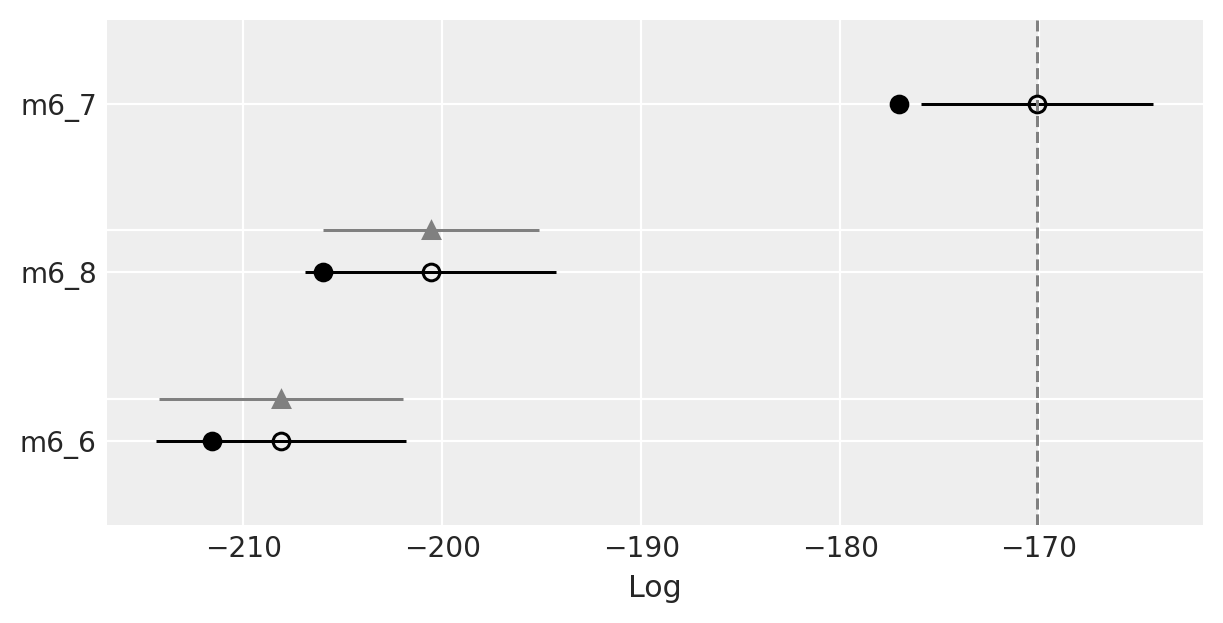

In [62]:
pm.compareplot(df_comp_WAIC)
# az.plot_compare(df_comp_WAIC)
plt.show()

The filled points are the in-sample deviance values. The open points are the WAIC values. Notice that naturally each model does better in-sample than it is expected to do out-of-sample.

The line segments show the standard error of each WAIC. These are the values in the column labeled SE in the table above.

What we really want however is the standard error of the difference in WAIC between the two models. That is shown by the lighter line segment with the triangle on it, between the two models.

The last element of the compare table is the column we skipped over, **weight**. These values are a traditional way to summarize relative support for each model. They always sum to 1, within a set of compared models. The weight of a model $i$ is computed as:

$w_i = \frac{exp(-0.5\Delta_i)}{\sum_{j}exp(-0.5\Delta_j)}$

where $\Delta_i$ is the difference between model $i$'s WAIC value and the best WAIC in the set. These are the dWAIC values in the table. These weights can be a quick way to see how big the differences are among models. But you still have to inspect the standard errors. Since the weights don’t reflect the standard errors, they are simply not sufficient for model comparison. Weights are also used in model averaging. 

### 7.5.2. Outliers and other illusions

### Code 7.32

In [63]:
# load waffle & divoce data
d = pd.read_csv("Data/WaffleDivorce.csv", sep=";", header=0)
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [64]:
# standardize the variables of interest
d['MedianAgeMarriage_std'] = (d.MedianAgeMarriage-d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['Marriage_std'] = (d.Marriage-d.Marriage.mean())/d.Marriage.std()
d['Divorce_std'] = (d.Divorce-d.Divorce.mean())/d.Divorce.std()
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_std,Marriage_std,Divorce_std
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


In [65]:
# define model: Divorce ~ MedianAgeMarriage
with pm.Model() as m5_1:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b_A*d['MedianAgeMarriage_std'])
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d['Divorce_std'])
    trace_m5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5226.19draws/s]


In [66]:
# define model Divorce ~ Marriage
with pm.Model() as m5_2:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b_M*d['Marriage_std'])
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d['Divorce_std'])
    trace_m5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5136.49draws/s]


In [67]:
# define model Divorce ~ Marriage + MedianAgeMarriage
with pm.Model() as m5_3:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b_M*d['Marriage_std']+b_A*d['MedianAgeMarriage_std'])
    Divorce = pm.Normal('Divorce', mu=mu, sigma=sigma, observed=d['Divorce_std'])
    trace_m5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3777.42draws/s]
The acceptance probability does not match the target. It is 0.8794901648572012, but should be close to 0.8. Try to increase the number of tuning steps.


### Code 7.33

In [68]:
df_comp_PSIS= pm.compare({'m5_1': trace_m5_1, 
                          'm5_2': trace_m5_2, 
                          'm5_3': trace_m5_3}, ic='LOO')
df_comp_PSIS

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_1,0,-62.9717,3.72145,0,0.62683,6.33166,0,False,log
m5_3,1,-63.7587,4.70378,0.786988,0.292006,4.66135,0.372545,False,log
m5_2,2,-69.7998,3.08793,6.82807,0.0811638,6.29047,4.66567,False,log


### Code 7.35

One way to both use these extreme observations and reduce their influence is to employ some kind of robust regression. A “robust regression” can mean many different things, but usually it indicates a linear model in which the influence of extreme observations is reduced. A common and useful kind of robust regression is to replace the Gaussian model with a thicker-tailed distribution like Student's t(or"Student-t") distribution.

In [69]:
# define model Divorce ~ Marriage + MedianAgeMarriage
with pm.Model() as m5_3t:
    a = pm.Normal('a', mu=0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+b_M*d['Marriage_std']+b_A*d['MedianAgeMarriage_std'])
    Divorce = pm.StudentT('Divorce', nu=2, mu=mu, sigma=sigma, observed=d['Divorce_std'])
    trace_m5_3t = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, b_A, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4102.87draws/s]


In [70]:
df_comp_PSIS= pm.compare({'m5_1': trace_m5_1, 
                          'm5_2': trace_m5_2, 
                          'm5_3t': trace_m5_3t}, ic='LOO')
df_comp_PSIS

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_1,0,-62.9717,3.72145,0,0.829933,6.25321,0,False,log
m5_3t,1,-66.4631,6.16467,3.49132,0.101718,4.96413,2.97558,False,log
m5_2,2,-69.7998,3.08793,6.82807,0.0683494,5.65539,4.66567,False,log


In [71]:
# show model summary
varnames = ['~mu']
az.summary(trace_m5_3, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,-0.00,0.10,-0.18,0.14
b_A,-0.61,0.16,-0.86,-0.36
b_M,-0.06,0.16,-0.31,0.19
sigma,0.83,0.09,0.69,0.96


In [72]:
# show model summary
varnames = ['~mu']
az.summary(trace_m5_3t, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.03,0.10,-0.14,0.18
b_A,-0.69,0.15,-0.92,-0.43
b_M,0.06,0.21,-0.28,0.39
sigma,0.58,0.09,0.44,0.71


In [73]:
# point wise values
m5_1_loo = pm.stats.loo(trace_m5_3, pointwise=True, reff=None, scale='deviance')
m5_1_loo['loo_i'].values
m5_1_waic = pm.stats.waic(trace_m5_3, pointwise=True, scale='deviance')
m5_1_waic['waic_i'].values

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


array([ 4.07128176,  3.96437875,  1.83594884,  4.46185591,  1.98563638,
        2.848037  ,  2.86257641,  1.54122781,  1.76845732,  1.92319683,
        2.87726904,  1.72066983, 12.29073547,  1.86218742,  1.92317527,
        1.47728894,  1.48632341,  3.11482747,  2.11970435,  7.71842154,
        1.50615775,  1.56405481,  1.53189085,  3.91007483,  2.09706285,
        1.67707101,  1.9049593 ,  2.51184342,  1.92716425,  4.0237903 ,
        1.51239277,  2.13686992,  1.47758519,  3.86142976,  1.49241366,
        2.96232756,  1.65665008,  2.16582808,  2.58879499,  2.29914659,
        1.77549323,  1.9021873 ,  1.55642904,  3.04703528,  1.63246527,
        1.57496346,  1.49535303,  1.53802289,  2.21599404,  1.91339687])

In [74]:
pm.stats.waic(trace_m5_3, pointwise=True)

Computed from 4000 by 50 log-likelihood matrix

          Estimate       SE
elpd_waic   -63.66     6.31
p_waic        4.60        -

There has been a warning during the calculation. Please check the results.

### Referece

[pymc-devs: Rethinking_1 Chp06](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynbb)